In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
%matplotlib inline
from os import listdir
import time, cv2
from sklearn import cluster, metrics,  manifold, decomposition
from collections import Counter

In [2]:
df = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")

## Création des labels des photos

In [3]:
df['product_category'] = df['product_category_tree'].apply(lambda x: x.split(" >>")[0][2:])
df = df[['image', 'product_category']]
df.head()

,image,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing


In [4]:
df.groupby('product_category')[['image']].count()

,image
product_category,
Baby Care,150
Beauty and Personal Care,150
Computers,150
Home Decor & Festive Needs,150
Home Furnishing,150
Kitchen & Dining,150
Watches,150


In [5]:
path = 'data/Images/'
list_photos = listdir(path)
print(len(list_photos))

1050


## Affichage d'exemples d'images par label

In [6]:
list_baby_care = list(df[df['product_category'] == 'Baby Care']['image'])
list_beauty_personal_care = list(df[df['product_category'] == 'Beauty and Personal Care']['image'])
list_computers = list(df[df['product_category'] == 'Computers']['image'])
list_decore_festive_needs = list(df[df['product_category'] == 'Home Decor & Festive Needs']['image'])
list_home_furnishing = list(df[df['product_category'] == 'Home Furnishing']['image'])
list_kitchen_dining = list(df[df['product_category'] == 'Kitchen & Dining']['image'])
list_watches = list(df[df['product_category'] == 'Watches']['image'])

In [7]:
def list_fct(name) :
    return list(df[df["product_category"] == name]['image'])

Home Furnishing


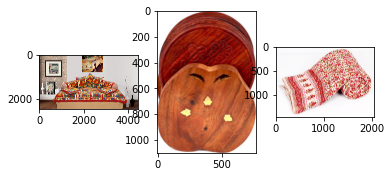

Baby Care


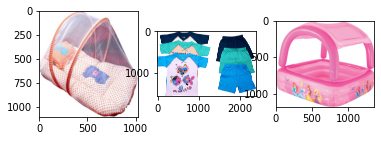

Watches


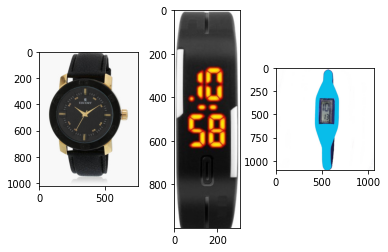

Home Decor & Festive Needs


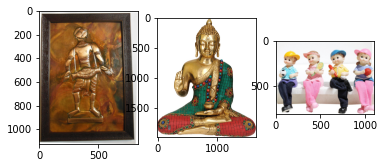

Kitchen & Dining


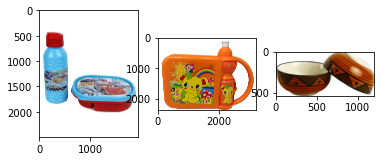

Beauty and Personal Care


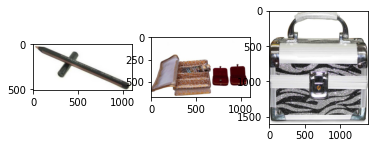

Computers


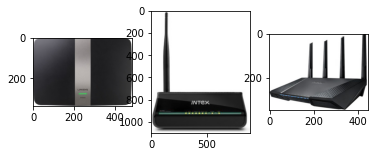

In [8]:
for name in df['product_category'].unique():
    print(name)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

## Détermination et affichage des descripteurs SIFT

- L'image contient 73 descripteurs
- Chaque descripteur est un vecteur de longueur 128

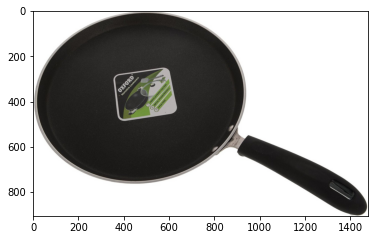

In [9]:
image = imread(path + list_photos[1])
plt.imshow(image)
plt.show()

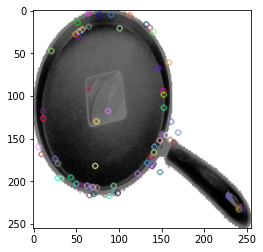

Descripteurs :  (73, 128)

[[167.   7.   0. ...   0.   0.   0.]
 [143.  18.   0. ...   0.   0.   0.]
 [ 24.   0.   0. ...   7.   0.   1.]
 ...
 [ 23.   0.   0. ...   0.   0.  81.]
 [ 21.   0.   0. ...   0.   0. 139.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [10]:
sift = cv2.SIFT_create(500)
image = cv2.imread(path + list_photos[1], 0) # convert in gray
image = cv2.GaussianBlur(image, (5,5), cv2.BORDER_DEFAULT)
image = cv2.equalizeHist(image)   # equalize image histogram
image = cv2.resize(image, (255, 255), interpolation=cv2.INTER_AREA)
kp, des = sift.detectAndCompute(image, None)
img = cv2.drawKeypoints(image, kp, image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

# Pré-traitement des images via SIFT

## Créations des descripteurs de chaque image

- Pour chaque image passage en gris et equalisation
- création d'une liste de descripteurs par image (`sift_keypoints_by_img`) qui sera utilisée pour réaliser les histogrammes par image
- création d'une liste de descripteurs pour l'ensemble des images (`sift_keypoints_all`) qui sera utilisé pour créer les clusters de descripteurs

In [11]:
# identification of key points and associated descriptors
sift_keypoints = []
temps1 = time.time()
sift = cv2.SIFT_create(500)

for image_num in range(len(list_photos)):
    if image_num % 100 == 0:
        print(image_num)
    image = cv2.imread(path + list_photos[image_num], 0)  # convert in gray
    image =cv2.GaussianBlur(image, (5, 5), cv2.BORDER_DEFAULT)
    image = cv2.equalizeHist(image)   # equalize image histogram
    res = cv2.resize(image, (255, 255), interpolation=cv2.INTER_AREA)  # resize image 
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1 = time.time() - temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (367594, 128)
temps de traitement SIFT descriptor :            63.04 secondes


C:\Users\Quentin\AppData\Local\Temp/ipykernel_10716/3888139392.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)


In [12]:
sift_keypoints_by_img[1].shape

(73, 128)

## Création des clusters de descripteurs

- Utilisation de `MiniBatchKMeans` pour obtenir des temps de traitement raisonnables

In [13]:
# Determination number of clusters
temps1 = time.time()

# k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
k = 595
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1 = time.time() - temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  595
Création de 595 clusters de descripteurs ...
temps de traitement kmeans :            11.40 secondes


In [14]:
sift_keypoints_by_img[0]

array([[52.,  3.,  2., ...,  0.,  0.,  0.],
       [53., 34.,  0., ...,  0.,  0.,  1.],
       [56., 21.,  3., ...,  0.,  0.,  2.],
       ...,
       [13., 28., 54., ..., 33., 38., 12.],
       [12.,  5.,  6., ...,  2.,  0., 16.],
       [ 5.,  1.,  0., ...,  5.,  6.,  6.]], dtype=float32)

In [15]:
# 500 descripteurs de longueur 128
sift_keypoints_by_img[0].shape

(500, 128)

In [16]:
# chaque descripteur est affectée à un cluster
res = kmeans.predict(sift_keypoints_by_img[0])
res

array([566, 453, 124, 342,  23, 566, 373,  32,  20, 124, 313,  12, 298,
       515, 589, 124, 413, 129, 124, 445, 102, 511, 198, 124, 566, 413,
       280, 109, 564, 226, 565,  84, 124, 198,  60, 412, 373, 315, 124,
       445, 208, 100, 124, 439, 589, 270, 421, 412,  59, 478, 403, 149,
       124, 282,  70, 332, 226, 413, 347, 102, 149,  70, 315, 199,  67,
       368, 199, 371, 183, 589, 111, 212, 562, 588, 589, 429, 384, 171,
        30,  25,  55, 102, 149, 587, 215, 201, 429, 434,  55, 429, 149,
       182,  82, 199,  49, 564, 102, 199, 483, 427, 199, 575,  81, 184,
       511, 395, 199, 172, 125, 330,  39,  55, 102, 149, 199, 217,  94,
        98,  18, 111,  33, 441, 376,  54, 228, 333, 226, 188, 333, 327,
        55,   3, 419, 401, 555, 402, 501, 582,  55, 138,  55, 149,   0,
       428, 505,  30, 256,  55, 579, 149, 102, 149, 172,  12, 514, 184,
       330,  39,  39, 591, 328, 589, 119, 524, 330,   1,  92, 210,  55,
        39, 330, 527, 527,  55,  31, 348, 330, 408,  55,  55, 42

In [17]:
hist = np.zeros(len(kmeans.cluster_centers_))
hist

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [18]:
nb_des = len(sift_keypoints_by_img[0])
nb_des

500

In [19]:
for i in res:
    hist[i] = hist[i] + 1.0/nb_des  ## normalisation

In [20]:
hist

array([0.006, 0.002, 0.   , 0.002, 0.002, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.004, 0.   , 0.   , 0.002, 0.   , 0.   ,
       0.004, 0.   , 0.004, 0.002, 0.002, 0.002, 0.   , 0.002, 0.   ,
       0.   , 0.002, 0.   , 0.006, 0.002, 0.002, 0.012, 0.002, 0.   ,
       0.   , 0.   , 0.   , 0.014, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.002, 0.   , 0.   , 0.01 , 0.002, 0.002, 0.   , 0.   , 0.002,
       0.002, 0.042, 0.   , 0.004, 0.   , 0.006, 0.006, 0.   , 0.   ,
       0.   , 0.   , 0.004, 0.002, 0.002, 0.   , 0.   , 0.004, 0.   ,
       0.   , 0.   , 0.   , 0.004, 0.   , 0.   , 0.004, 0.   , 0.002,
       0.014, 0.01 , 0.   , 0.01 , 0.002, 0.   , 0.   , 0.   , 0.   ,
       0.004, 0.   , 0.002, 0.002, 0.004, 0.   , 0.002, 0.   , 0.002,
       0.   , 0.002, 0.   , 0.026, 0.002, 0.   , 0.   , 0.   , 0.   ,
       0.002, 0.002, 0.   , 0.008, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.002, 0.   , 0.   , 0.   , 0.   , 0.018, 0.004,
       0.004, 0.   ,

In [21]:
np.sum(hist)

1.0

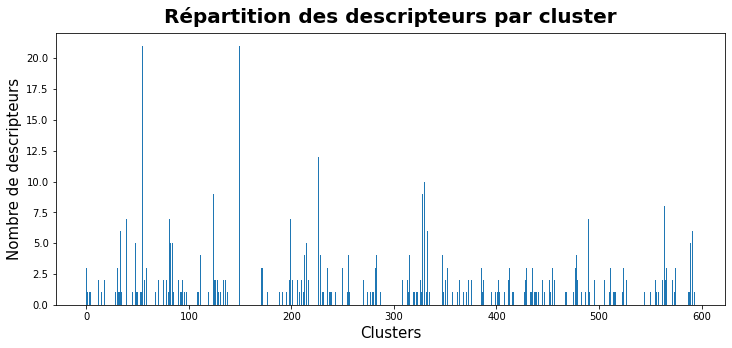

In [22]:
plt.figure(figsize = (12, 5))
plt.title("Répartition des descripteurs par cluster", 
          fontsize=20, pad=10, fontweight='bold')
plt.ylabel("Nombre de descripteurs", fontsize=15)
plt.xlabel("Clusters", fontsize=15)
plt.bar(Counter(res).keys(), Counter(res).values())
plt.show()

## Création des features des images
- Pour chaque image :
  - prédiction des numéros de cluster de chaque descripteur
  - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image
  
Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [23]:
# Creation of histograms (features)
temps1 = time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0: 
        print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0: 
        print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :           128.72 secondes


In [24]:
im_features.shape

(1050, 595)

In [25]:
im_features[0]

array([0.006, 0.002, 0.   , 0.002, 0.002, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.004, 0.   , 0.   , 0.002, 0.   , 0.   ,
       0.004, 0.   , 0.004, 0.002, 0.002, 0.002, 0.   , 0.002, 0.   ,
       0.   , 0.002, 0.   , 0.006, 0.002, 0.002, 0.012, 0.002, 0.   ,
       0.   , 0.   , 0.   , 0.014, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.002, 0.   , 0.   , 0.01 , 0.002, 0.002, 0.   , 0.   , 0.002,
       0.002, 0.042, 0.   , 0.004, 0.   , 0.006, 0.006, 0.   , 0.   ,
       0.   , 0.   , 0.004, 0.002, 0.002, 0.   , 0.   , 0.004, 0.   ,
       0.   , 0.   , 0.   , 0.004, 0.   , 0.   , 0.004, 0.   , 0.002,
       0.014, 0.01 , 0.   , 0.01 , 0.002, 0.   , 0.   , 0.   , 0.   ,
       0.004, 0.   , 0.002, 0.002, 0.004, 0.   , 0.002, 0.   , 0.002,
       0.   , 0.002, 0.   , 0.026, 0.002, 0.   , 0.   , 0.   , 0.   ,
       0.002, 0.002, 0.   , 0.008, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.002, 0.   , 0.   , 0.   , 0.   , 0.018, 0.004,
       0.004, 0.   ,

In [26]:
im_features_df = pd.DataFrame(im_features)
im_features_df.to_csv('data/im_features_sift.csv')

## Réductions de dimension


### Réduction de dimension PCA

- La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
- L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [27]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 595)
Dimensions dataset après réduction PCA :  (1050, 475)


###  Réduction de dimension T-SNE
-  Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [28]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["product_category"]
print(df_tsne.shape)

C:\Users\Quentin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images

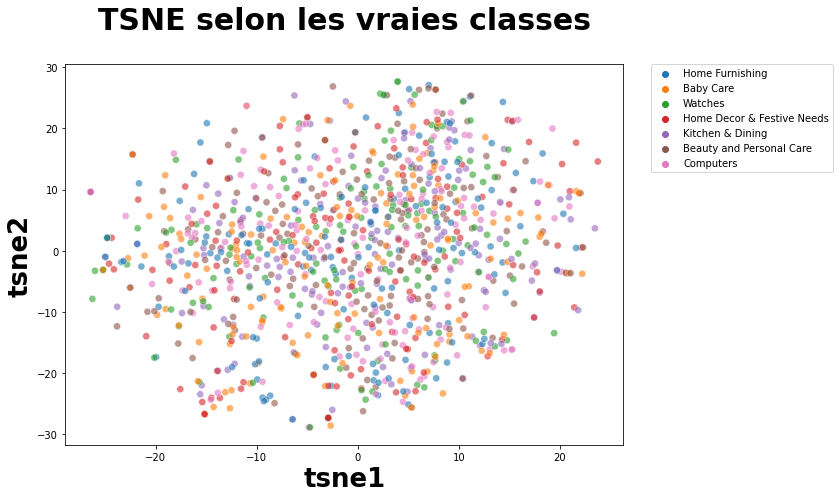

In [29]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
# plt.legend(prop={'size': 14}) 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Analyse mesures : similarité entre catégories et clusters

### Création de clusters à partir du T-SNE

In [30]:
cls = cluster.KMeans(n_clusters=7, random_state=42)
cls.fit(X_tsne)
df_tsne["cluster"] = cls.labels_
df_tsne.head(3)

,tsne1,tsne2,class,cluster
0,-0.211817,19.384405,Home Furnishing,4
1,-19.840004,-10.501775,Baby Care,1
2,-12.481480,-22.843296,Baby Care,2


In [31]:
labels = df["product_category"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

ARI :  0.0008785111319255179


## Analyse par classes

In [32]:
df_tsne.groupby("cluster")[["class"]].count()

,class
cluster,
0,163
1,162
2,103
3,195
4,167
5,161
6,99


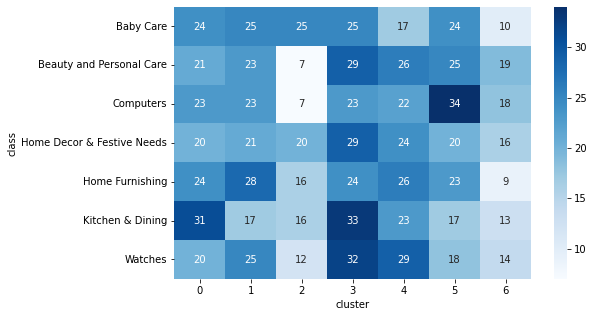

In [33]:
plt.figure(figsize=(8, 5))
sns.heatmap(pd.crosstab(df_tsne['class'], df_tsne['cluster']),
            annot=True,
            cmap="Blues")
plt.show()